# Data Collection

Avito uses javascript to dynamically load images. This rules out a beautiful soup and requests combination. Google webcrawlers index all images on pages in the google search results though so the same images show up in the google search results if you add avito the search query on google images. Thus the following approach achieves the same goal with less work.  

### Imports

In [ ]:

from google_images_download import google_images_download

### Script

In [ ]:
response = google_images_download.googleimagesdownload()

search_queries = [
    'iphone 7',
    'iphone 7+',
    'iphone 8',
    'iphone 5s',
    'iphone 6s',
    'iphone xs',
    'iPhone X',
    'iPhone 8 Plus',
    'iPhone 8',
    'iPhone 7 Plus',
    'iPhone SE',
    'iPhone 6s Plus',
    'iPhone 6s'
]


def downloadimages(query):
    arguments = {"keywords": 'avito ' + query,
                 "format": "jpg",
                 "limit": 100,
                 "print_urls": True,
                 "size": "medium"}
    try:
        response.download(arguments)

    except FileNotFoundError:
        arguments = {"keywords": query,
                     "format": "jpg",
                     "limit": 4,
                     "print_urls": True,
                     "size": "medium"}
        try:
            response.download(arguments)
        except:
            pass


# Download a list of phone names and load them to get all none iphones 
# (and uncomment the next lines)
# with open('phones.txt', 'r') as file:
#    query = file.read().split('\n')
for query in search_queries:
    print(query)
    for q in query:
        downloadimages(q)



# Machine Learning 

Since this is what appears to be the classical cat/dog kind of exercise

### Imports

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from keras.applications import ResNet50
from TrainingPlot import TrainingPlot


from keras import optimizers
import os

### Loading the data

The data will be loaded using the keras ImageDataGenerator alongside it's function flow_from_directory. Thus the following data structure is mandatory:
data
  |
   ---> Train
          |
           ---> Iphone
          |
           ---> Other
  |
   ---> Test
          |
           ---> Iphone
          |
           ---> Other

In [ ]:
# Mandatory structure for data

#data
#  |
#   ---> Train
#          |
#           ---> Iphone
#          |
#           ---> Other
#  |
#   ---> Test
#          |
#           ---> Iphone
#          |
#           ---> Other

image_size = 224

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                            vertical_flip=True,
                                            rotation_range=10,
                                            width_shift_range=0.3,
                                            height_shift_range=0.3)

gen = datagen.flow_from_directory('./data/Train', target_size=(image_size, image_size),
                                  color_mode='rgb', classes=None,
                                  class_mode='categorical', batch_size=32,
                                  shuffle=True, interpolation='nearest')

test_gen = datagen.flow_from_directory('./data/Test', target_size=(image_size, image_size),
                                  color_mode='rgb', classes=None,
                                  class_mode='categorical', batch_size=32,
                                  shuffle=True, interpolation='nearest')

### Visualisation

In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class TrainingPlot(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))

        if len(self.losses) > 1:
            N = np.arange(0, len(self.losses))
            plt.figure()
            plt.plot(N, self.losses, label="train_loss")
            plt.plot(N, self.acc, label="train_acc")
            plt.plot(N, self.val_losses, label="val_loss")
            plt.plot(N, self.val_acc, label="val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()

            try:
                os.mkdir('outdir')
            except FileExistsError:
                pass
            plt.savefig('output/Epoch-{}.png'.format(epoch))
            plt.close()



### VG19

In [ ]:
plot_losses = TrainingPlot()

model = Sequential()

model.add(VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3)))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()

optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(generator=gen, validation_data=test_gen, epochs=100,
                    use_multiprocessing=True, workers=6, callbacks=[plot_losses])

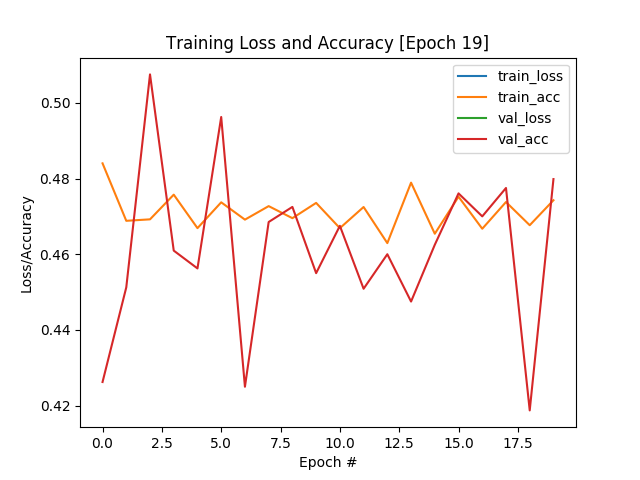

In [1]:
from IPython.display import Image
Image(filename='abgabe/VGG19_Epoch-19.png', width=400, height=600)

The network does not learn anything which then got me 

In [ ]:
plot_losses = TrainingPlot()

model = Sequential()

model.add(ResNet50(include_top=False, pooling='max', weights="imagenet"))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.layers[0].trainable = False
model.summary()

optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(generator=gen, validation_data=test_gen, epochs=100,
                    use_multiprocessing=True, workers=6, callbacks=[plot_losses])

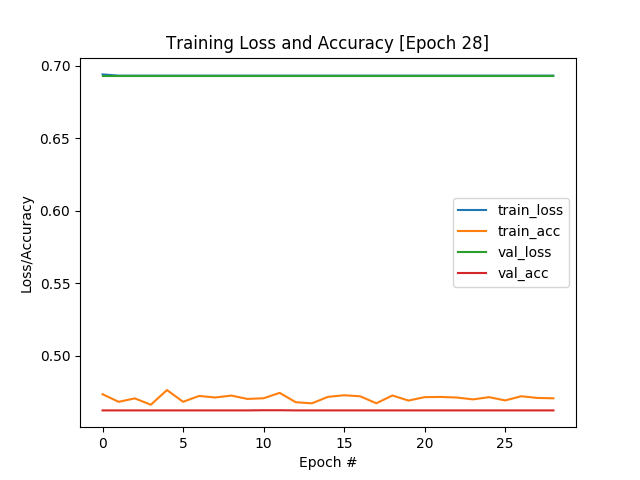

In [2]:
from IPython.display import Image
Image(filename='abgabe/ResNet50Epoch-28.png', width=400, height=600)

# Conclusion

Both networks didn't learn anything. Using resnet in similar scenarios and uppon closer inspection of the data it becomes apparent that I myself can only tell iphones from other phones appart if the apple logo is visible in the picture (which is very often not the case). 

Not knowing the specifics of the held out test set it is not possible to come up with a satisfying solution. The scores on our data set can be finetuned to be whatever we like by simply deleting images that are impossible to tell appart for a human.

Not knowing the test dataset this is unlikely to yield good results. 